# Plotting results from a scan

You should run `rsopt sample configuration config_madx.yml` in the command line before running this notebook.

This will execute a parameter scan that varies the strength (K1) of the UQ12 in 5 steps from -0.125 to +0.125.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pykern import pkyaml
from sirepo.template import madx_parser

# Load Results 

We will load the Twiss file `twiss.file.tfs` for each step in the scan and plot an example of the output

In [2]:
twiss_file = 'twiss.file.tfs'

Get the base path from the config file where rsopt stored the data for each step in the scan 

In [3]:
config = pkyaml.load_file('config_madx.yml')
data_path = pathlib.Path(config['options']['run_dir'])

The history file `H` is a structured NumPy array containing the the parameters that were varied at each step of the scan as well as information about the success/failure of each step and the worker (if rsopt was using multiple workers) that ran the simulation.

In [4]:
H = np.load('H_sample_config_madx_history_length=5_evals=5_workers=1.npy')

If there were multiple workers being used they will run independently and be given work whenever completed. So we can use the history file to figure out which step (`sim_id`) was run by which worker and read the Twiss file from the appropriate directory. This allows us to pair up the results with the parameter in `H['x']`.

In [5]:
scan_twiss = []

for worker, sim in zip(H['sim_worker'], H['sim_id']):
    scan_twiss.append(
        madx_parser.parse_tfs_file(
            data_path.joinpath(f'worker{worker}/sim{sim}').joinpath(twiss_file)
        )
    )

# Plot

As an example we plot $\beta_x$ from each step in the scan. The value of the quadrupole UQ12 being varied at each step can be retrieved from the history array using the 'x' field (H['x']). 

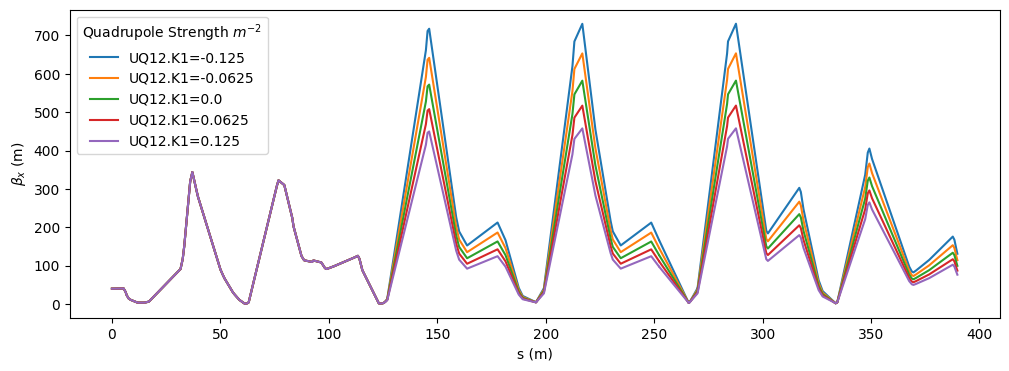

In [11]:
plt.figure(figsize=(12, 4))
for ff, k1 in zip(scan_twiss, H['x']):
    plt.plot(np.array(ff['s'], float), np.array(ff['betx'], float), label=f'UQ12.K1={k1[0]}')
    
plt.legend(title=r'Quadrupole Strength ($m^{-2}$)')
plt.xlabel('s (m)')
plt.ylabel(r'$\beta_x$ (m)')
plt.show()